# GKP Test

The purpose of this notebook is to determine how best to sweep GKP code parameters so that it can be accurately compared with binomial codes and random codes. Mainly, there is a need to establish a relationship between the energy constraint, the boson number cutoff, and the average boson number. TODO

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import multiprocess
import qutip as qt
from src import code_simulator, code, noise

### Parameters

In [2]:
energy_constraints = np.linspace(0.001, 0.01, 10)
truth_physical_dimension = 150
lower_bound_physical_dimension = 2

### Compare Physical Dimension Cutoffs for Fixed Energy Constraint

In [3]:
%%time
pool = multiprocess.Pool()

truth_gkps = [code.get_gkp_code(True, energy_constraint, truth_physical_dimension) for energy_constraint in energy_constraints]
test_gkp_code_processes = np.zeros((len(energy_constraints), truth_physical_dimension + 1 - lower_bound_physical_dimension)).tolist()
for i, energy_constraint in enumerate(energy_constraints):
	for j, number_cutoff in enumerate(range(lower_bound_physical_dimension, truth_physical_dimension + 1)):
		test_gkp_code_processes[i][j] = pool.apply_async(code.get_gkp_code, (True, energy_constraint, number_cutoff))
test_gkp_codes = np.zeros((len(energy_constraints), truth_physical_dimension + 1 - lower_bound_physical_dimension)).tolist()
for i, energy_constraint in enumerate(energy_constraints):
	for j, number_cutoff in enumerate(range(lower_bound_physical_dimension, truth_physical_dimension + 1)):
		test_gkp_codes[i][j] = test_gkp_code_processes[i][j].get()

code_similarities = np.zeros((len(energy_constraints), truth_physical_dimension + 1 - lower_bound_physical_dimension, 4))
for i, energy_constraint in enumerate(energy_constraints):
	for j, number_cutoff in enumerate(range(lower_bound_physical_dimension, truth_physical_dimension + 1)):
		for k, similarity in enumerate(code_simulator.compute_code_similarities(truth_gkps[i], test_gkp_codes[i][j])):
			code_similarities[i,j,k] = similarity

CPU times: user 523 ms, sys: 243 ms, total: 766 ms
Wall time: 730 ms


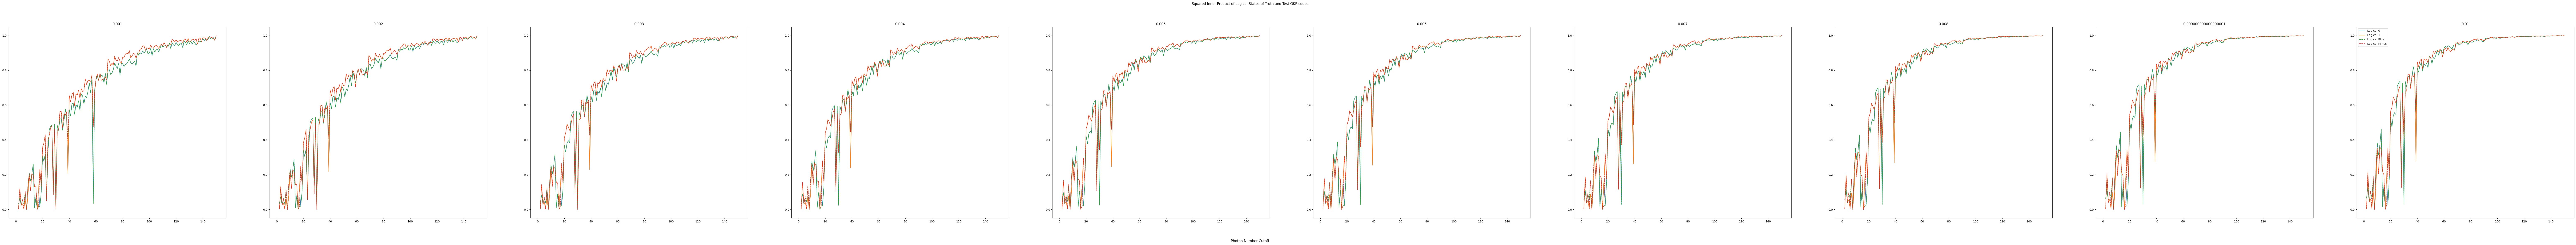

In [4]:
legend = ["Logical 0", "Logical 1", "Logical Plus", "Logical Minus"]
linestyles = ["solid", "solid", "dashed", "dashed"]
figure, axes = plt.subplots(1, len(energy_constraints), figsize=(16 * len(energy_constraints), 12))
if not isinstance(axes, np.ndarray):
	axes = [axes]
for i, energy_constraint in enumerate(energy_constraints):
	for j in range(4):
		axes[i].plot(range(lower_bound_physical_dimension, truth_physical_dimension + 1), code_similarities[i,:,j], label=legend[j], linestyle=linestyles[j])
		axes[i].set_title(energy_constraint)
figure.supxlabel("Photon Number Cutoff")
figure.suptitle("Squared Inner Product of Logical States of Truth and Test GKP codes")
axes[-1].legend()
plt.show()

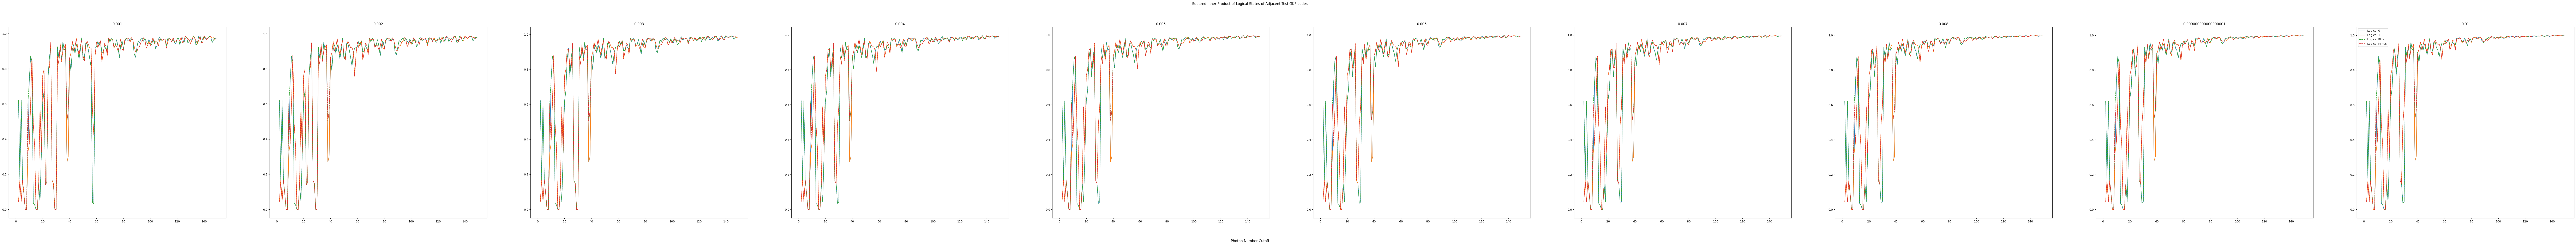

In [5]:
adjacent_code_similarities = np.zeros(code_similarities.shape)
for i in range(len(energy_constraints)):
	for j, test_gkp_code in enumerate(test_gkp_codes[i][:-1]):
		for k, similarity in enumerate(code_simulator.compute_code_similarities(test_gkp_code, test_gkp_codes[i][j + 1])):
			adjacent_code_similarities[i][j][k] = similarity

figure, axes = plt.subplots(1, len(energy_constraints), figsize=(len(energy_constraints) * 16, 12))
if not isinstance(axes, np.ndarray):
	axes = [axes]
for i, energy_constraint in enumerate(energy_constraints):
	for j in range(4):
		axes[i].plot(range(lower_bound_physical_dimension, truth_physical_dimension), adjacent_code_similarities[i,:-1,j], label=legend[j], linestyle=linestyles[j])
		axes[i].set_title(energy_constraint)
figure.supxlabel("Photon Number Cutoff")
figure.suptitle("Squared Inner Product of Logical States of Adjacent Test GKP codes")
axes[-1].legend()
plt.show()